In [1]:
# Init
import os
import glob
import sys
import pickle

module_path = os.path.abspath(os.path.join("../src/simulicronalpha/"))
if module_path not in sys.path:
    sys.path.append(module_path)

# Imports
import numpy as np
import pandas as pd
import warnings
import multiprocessing
np.set_printoptions(suppress=True)
from numpy import concatenate as c
from numpy import cumsum
import random

# Plotting imports
import altair as alt
alt.data_transformers.disable_max_rows()
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# Acc. functions
def returnLast(lst):
    return lst[-1]
def returnGen(lst, gen):
    return lst[gen]
def return100(lst):
    return lst[:100]
def colorRanges(i):
    if i == 0:
        return ("0")
    elif i > 0 and i <= 50:
        return ("1-50")
    elif i > 50 and i <= 100:
        return ("50-100")
    elif i > 100 and i <= 200:
        return ("100-200") 
    elif i > 200 and i <= 300:
        return ("200-300")         
    elif i > 300:
        return (">300")     
def zeroDivision(n, d):
    return n / d if d else maxVal

def TECNplotSD(df, ax):
    resultDFT1 = pd.DataFrame(data=np.array(df["TE_1_CN"].tolist()))
    resultDFT1exp = list(resultDFT1.mean())
    resultDFT1mdn = list(resultDFT1.median())
    resultDFT1std = list(resultDFT1.std())
    
    resultDFT2 = pd.DataFrame(data=np.array(df["TE_2_CN"].tolist()))
    resultDFT2exp = list(resultDFT2.mean())
    resultDFT2mdn = list(resultDFT2.median())
    resultDFT2std = list(resultDFT2.std())
    
    # Meld for long form
    nameColumn = ["TE1"] * len(resultDFT1exp) + ["TE2"] * len(resultDFT2exp)
    exp = resultDFT1exp + resultDFT2exp
    mdn = resultDFT1mdn + resultDFT2mdn
    std = resultDFT1std + resultDFT2std
    generation = list(range(len(resultDFT1exp))) + list(range(len(resultDFT2exp)))
    plotDF = pd.DataFrame({"TE":nameColumn, "Mean":exp, "Median":mdn, "std":std, "Generation": generation})
    sns.lineplot(x=list(range(len(resultDFT1exp))), y=resultDFT1exp, ax=ax)
    ax.fill_between(list(range(len(resultDFT1exp))), np.array(resultDFT1exp) - np.array(resultDFT1std), np.array(resultDFT1exp) + np.array(resultDFT1std), alpha=0.2)
    sns.lineplot(x=list(range(len(resultDFT2exp))), y=resultDFT2exp, ax=ax)
    ax.fill_between(list(range(len(resultDFT2exp))), np.array(resultDFT2exp) - np.array(resultDFT2std), np.array(resultDFT2exp) + np.array(resultDFT2std), alpha=0.2)

  
def TECNplot(df, ax):
    resultDFT1 = pd.DataFrame(data=np.array(df["TE_1_CN"].tolist()))
    resultDFT1exp = list(resultDFT1.mean())
    resultDFT1mdn = list(resultDFT1.median())
    resultDFT1std = list(resultDFT1.std())
    
    resultDFT2 = pd.DataFrame(data=np.array(df["TE_2_CN"].tolist()))
    resultDFT2exp = list(resultDFT2.mean())
    resultDFT2mdn = list(resultDFT2.median())
    resultDFT2std = list(resultDFT2.std())
    
    # Meld for long form
    nameColumn = ["TE1"] * len(resultDFT1exp) + ["TE2"] * len(resultDFT2exp)
    exp = resultDFT1exp + resultDFT2exp
    mdn = resultDFT1mdn + resultDFT2mdn
    std = resultDFT1std + resultDFT2std
    generation = list(range(len(resultDFT1exp))) + list(range(len(resultDFT2exp)))
    plotDF = pd.DataFrame({"TE":nameColumn, "Mean":exp, "Median":mdn, "std":std, "Generation": generation})
    sns.lineplot(data=plotDF, x="Generation", y="Mean", hue="TE", ax=ax)

In [3]:
# Path to results
resultDir = "../etaVsHG/"

# Add them to a list
resultList = []
for filename in glob.glob(os.path.join(resultDir, '*.pickle')):
    with open(filename, 'rb') as f:
        resultList.append(pickle.load(f))

# Store results in a dataframe
resultDataframe = pd.DataFrame(resultList)

In [4]:
# Create a copy for inplace handling
resultDataframeC = resultDataframe.copy()
# Remove dataframes with loss
resultDataframeC = resultDataframeC[resultDataframeC["State"]!="LOSS"]

In [5]:
# Perform some data wrangling2000
resultDataframeC[['TranspositionRate_1','TranspositionRate_2']] = pd.DataFrame(resultDataframeC.TRate.tolist(), index= resultDataframeC.index)
resultDataframeC[['TE_1_CN','TE_2_CN']] = resultDataframeC['TEfamilyCN'].apply(pd.Series)
resultDataframeC[['TE_1_RG','TE_2_RG']] = resultDataframeC['TEfamilyRg'].apply(pd.Series)
resultDataframeC[['TE_1_pi','TE_2_pi']] = resultDataframeC['TEpi'].apply(pd.Series)

# Add column for the last acn (average copy number) for each transposon family
resultDataframeC['TE_1_ACN'] = resultDataframeC['TE_1_CN'].apply(lambda x: returnLast(x))
resultDataframeC['TE_2_ACN'] = resultDataframeC['TE_2_CN'].apply(lambda x: returnLast(x))
# resultDataframeC['TE_1_ACN'] = resultDataframeC['TE_1_CN'].apply(lambda x: returnGen(x))
# resultDataframeC['TE_2_ACN'] = resultDataframeC['TE_2_CN'].apply(lambda x: returnGen(x))

# Add column for the generation number at 100 (list)
resultDataframeC['TE_1_ACN100'] = resultDataframeC['TE_1_CN'].apply(lambda x: return100(x))
resultDataframeC['TE_2_ACN100'] = resultDataframeC['TE_2_CN'].apply(lambda x: return100(x))

# Add column for the generation number at 100
resultDataframeC['TE_1_100CN'] = resultDataframeC['TE_1_CN'].apply(lambda x: returnGen(x,1500))
resultDataframeC['TE_2_100CN'] = resultDataframeC['TE_2_CN'].apply(lambda x: returnGen(x,1500))

# Get ranges for adding colors later
resultDataframeC['TE_1_ACN_R'] = resultDataframeC['TE_1_ACN'].apply(lambda x: colorRanges(x))
resultDataframeC['TE_2_ACN_R'] = resultDataframeC['TE_2_ACN'].apply(lambda x: colorRanges(x))

# Add column for copies not present in clusters
resultDataframeC['TE_1_NCN'] = resultDataframeC['TE_1_ACN'] - resultDataframeC['TE_1_pi']
resultDataframeC['TE_2_NCN'] = resultDataframeC['TE_2_ACN'] - resultDataframeC['TE_2_pi']
resultDataframeC['TE_1_NCN_l'] = np.log(resultDataframeC['TE_1_ACN'] - resultDataframeC['TE_1_pi'])
resultDataframeC['TE_2_NCN_l'] = np.log(resultDataframeC['TE_2_ACN'] - resultDataframeC['TE_2_pi'])

# Add a ratio column!
# First find the highest value in the whole column
maxVal = resultDataframeC['TE_1_100CN'].max()
resultDataframeC['TE_100R'] = resultDataframeC.apply(lambda x: zeroDivision(x['TE_1_100CN'], x['TE_2_100CN']), axis=1)
resultDataframeC['TE_R'] = resultDataframeC.apply(lambda x: zeroDivision(x['TE_1_ACN'], x['TE_2_ACN']), axis=1)

# Some wrangling for plotly go
x = resultDataframeC['ETA']
y = resultDataframeC['selPen']
TE1ACN = resultDataframeC['TE_1_ACN']
TE2ACN = resultDataframeC['TE_2_ACN']

# Convert count to log scale
resultDataframeC['TE_1_ACN_l'] = np.log(resultDataframeC['TE_1_ACN'])
resultDataframeC['TE_2_ACN_l'] = np.log(resultDataframeC['TE_2_ACN'])

/home/siddharth/mambaforge/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# Select transposition rate
resultDataframeC = resultDataframeC[resultDataframeC["TranspositionRate_1"]==0.01]

In [7]:
# Partition based on the conditions
resultDataframeH1000E0 = resultDataframeC[(resultDataframeC["ETA"] == 0) & (resultDataframeC["HGTGen"] == 100)]
resultDataframeH1000E1 = resultDataframeC[(resultDataframeC["ETA"] == 1) & (resultDataframeC["HGTGen"] == 100)]
resultDataframeH0000E0 = resultDataframeC[(resultDataframeC["ETA"] == 0) & (resultDataframeC["HGTGen"] == 0)]
resultDataframeH0000E1 = resultDataframeC[(resultDataframeC["ETA"] == 1) & (resultDataframeC["HGTGen"] == 0)]

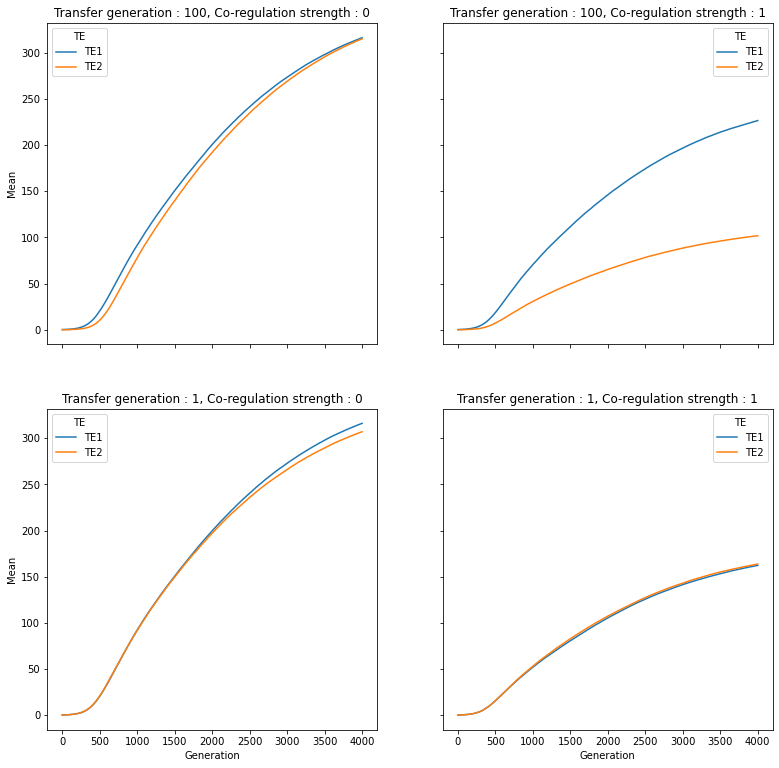

In [8]:
# Create a multipanel figure
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(13,13))
(ax1, ax2), (ax3, ax4) = axs
TECNplot(resultDataframeH1000E0,ax1)
ax1.title.set_text('Transfer generation : 100, Co-regulation strength : 0')
TECNplot(resultDataframeH1000E1,ax2)
ax2.title.set_text('Transfer generation : 100, Co-regulation strength : 1')
TECNplot(resultDataframeH0000E0,ax3)
ax3.title.set_text('Transfer generation : 1, Co-regulation strength : 0')
TECNplot(resultDataframeH0000E1,ax4)
ax4.title.set_text('Transfer generation : 1, Co-regulation strength : 1')